<a href="https://colab.research.google.com/github/AshOne91/PLAYDATA-COLAB/blob/main/%5BBaseline%5D_XGBoost%EB%A5%BC_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%B1%84%EB%AC%B4_%EB%B6%88%EC%9D%B4%ED%96%89_%EC%97%AC%EB%B6%80_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/dacon_02/open.zip

Archive:  /content/drive/MyDrive/dacon_02/open.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## 2. Data Load

In [ ]:
# 학습/평가 데이터 로드
train_df = pd.read_csv('./train.csv').drop(columns=['UID'])
test_df = pd.read_csv('./test.csv').drop(columns=['UID'])
train_df.columns

Index(['주거 형태', '연간 소득', '현재 직장 근속 연수', '체납 세금 압류 횟수', '개설된 신용계좌 수',
       '신용 거래 연수', '최대 신용한도', '신용 문제 발생 횟수', '마지막 연체 이후 경과 개월 수', '개인 파산 횟수',
       '대출 목적', '대출 상환 기간', '현재 대출 잔액', '현재 미상환 신용액', '월 상환 부채액', '신용 점수',
       '채무 불이행 여부'],
      dtype='object')

<Axes: >

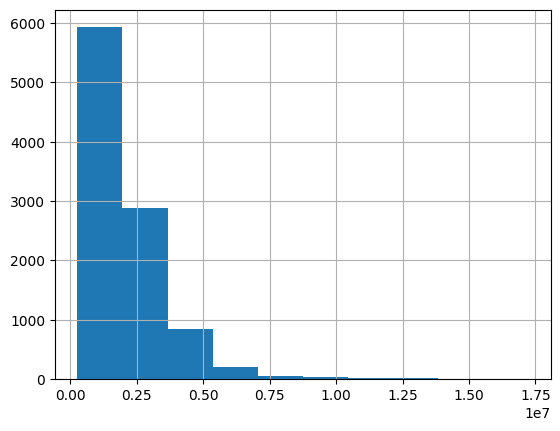

In [ ]:
train_df['연간 소득'].hist()

10000000.0

In [ ]:
# 연간소득이 0.75 1e7이상인 데이터는 제외
# train_df = train_df[train_df['연간 소득'] < 0.75+1e7]
# 연간소득을 3구간으로 구분
train_df['연간 소득'] = pd.qcut(train_df['연간 소득'], 3, labels=['low', 'middle', 'high'])
test_df['연간 소득'] = pd.qcut(test_df['연간 소득'], 3, labels=['low', 'middle', 'high'])

# 잔액 대비 신용 한도 비율 = 현재 대출 잔액 / 최대 신용한도
train_df['잔액 대비 신용 한도 비율'] = train_df['현재 대출 잔액'] / train_df['최대 신용한도']
train_df.drop(columns=['현재 대출 잔액','최대 신용한도'], inplace=True)
test_df['잔액 대비 신용 한도 비율'] = test_df['현재 대출 잔액'] / test_df['최대 신용한도']
test_df.drop(columns=['현재 대출 잔액','최대 신용한도'], inplace=True)
# 연체 위험 점수 = 신용 점수 - 신용 문제 발생 횟수
train_df['연체 위험 점수'] = train_df['신용 점수'] - train_df['신용 문제 발생 횟수']
train_df.drop(columns=['신용 점수','신용 문제 발생 횟수'], inplace=True)
test_df['연체 위험 점수'] = test_df['신용 점수'] - test_df['신용 문제 발생 횟수']
test_df.drop(columns=['신용 점수','신용 문제 발생 횟수'], inplace=True)


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9957 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   주거 형태              9957 non-null   object  
 1   연간 소득              9957 non-null   category
 2   현재 직장 근속 연수        9957 non-null   object  
 3   체납 세금 압류 횟수        9957 non-null   float64 
 4   개설된 신용계좌 수         9957 non-null   int64   
 5   신용 거래 연수           9957 non-null   float64 
 6   마지막 연체 이후 경과 개월 수  9957 non-null   int64   
 7   개인 파산 횟수           9957 non-null   int64   
 8   대출 목적              9957 non-null   object  
 9   대출 상환 기간           9957 non-null   object  
 10  현재 미상환 신용액         9957 non-null   float64 
 11  월 상환 부채액           9957 non-null   float64 
 12  채무 불이행 여부          9957 non-null   int64   
 13  잔액 대비 신용 한도 비율     9957 non-null   float64 
 14  연체 위험 점수           9957 non-null   int64   
dtypes: category(1), float64(5), int64(5), object(4)
memory usage

In [ ]:
# 연속형 변수 스케일링
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
numeric_cols_train = train_df.select_dtypes(include='number').columns
numeric_cols_test = test_df.select_dtypes(include='number').columns
print('무한대 값', (train_df[numeric_cols_train] == float('inf')).sum())

# 무한대 값을 NaN으로 대체
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 값 처리 (예: 평균으로 대체)
train_df[numeric_cols_test] = train_df[numeric_cols_test].fillna(train_df[numeric_cols_test].mean())
test_df[numeric_cols_test] = test_df[numeric_cols_test].fillna(test_df[numeric_cols_test].mean())

train_df[numeric_cols_test] = scaler.fit_transform(train_df[numeric_cols_test])
test_df[numeric_cols_test] = scaler.fit_transform(test_df[numeric_cols_test])
train_df.head()

무한대 값 체납 세금 압류 횟수            0
개설된 신용계좌 수             0
신용 거래 연수               0
마지막 연체 이후 경과 개월 수      0
개인 파산 횟수               0
현재 미상환 신용액             0
월 상환 부채액               0
채무 불이행 여부              0
잔액 대비 신용 한도 비율       388
연체 위험 점수               0
dtype: int64


,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,마지막 연체 이후 경과 개월 수,개인 파산 횟수,대출 목적,대출 상환 기간,현재 미상환 신용액,월 상환 부채액,채무 불이행 여부,잔액 대비 신용 한도 비율,연체 위험 점수
0,자가,middle,10년 이상,0.0,-0.500000,-0.478947,-0.148148,1.0,부채 통합,단기 상환,-0.089511,-0.574759,0,0.599230,0.123596
1,월세,middle,10년 이상,0.0,-1.166667,-0.300000,-0.629630,0.0,부채 통합,단기 상환,-0.579876,0.243071,0,3.289428,0.123596
2,월세,low,4년,0.0,0.000000,0.089474,1.703704,3.0,부채 통합,단기 상환,0.710491,-0.409598,1,-0.165728,0.483146
3,월세,low,6년,0.0,0.500000,-0.331579,-0.222222,1.0,부채 통합,단기 상환,0.483376,0.586681,1,0.054606,0.438202
4,월세,high,2년,0.0,-0.166667,0.857895,0.148148,0.0,부채 통합,장기 상환,-0.536418,-0.723821,0,1.081847,-0.056180


## 3. Pre-processing (전처리)

In [ ]:
categorical_col = [
    '연간 소득',
    '주거 형태',
    '현재 직장 근속 연수',
    '대출 목적',
    '대출 상환 기간'
]

# OneHotEncoder 초기화
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# 훈련 데이터에 대해 인코더 학습
encoder.fit(train_df[categorical_col])

# 훈련 데이터와 테스트 데이터 변환
train_encoded = encoder.transform(train_df[categorical_col])
test_encoded = encoder.transform(test_df[categorical_col])

# One-hot encoding 결과를 데이터프레임으로 변환
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(categorical_col))
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(categorical_col))

# 인코딩된 결과를 원래 데이터에 적용
train_df = pd.concat([train_df.drop(columns=categorical_col).reset_index(drop=True), train_encoded_df], axis=1)
test_df = pd.concat([test_df.drop(columns=categorical_col).reset_index(drop=True), test_encoded_df], axis=1)
train_df.shape, test_df.shape

((10000, 44), (2062, 43))

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   체납 세금 압류 횟수             10000 non-null  float64
 1   개설된 신용계좌 수              10000 non-null  float64
 2   신용 거래 연수                10000 non-null  float64
 3   마지막 연체 이후 경과 개월 수       10000 non-null  float64
 4   개인 파산 횟수                10000 non-null  float64
 5   현재 미상환 신용액              10000 non-null  float64
 6   월 상환 부채액                10000 non-null  float64
 7   채무 불이행 여부               10000 non-null  int64  
 8   잔액 대비 신용 한도 비율          10000 non-null  float64
 9   연체 위험 점수                10000 non-null  float64
 10  연간 소득_high              10000 non-null  float64
 11  연간 소득_low               10000 non-null  float64
 12  연간 소득_middle            10000 non-null  float64
 13  주거 형태_월세                10000 non-null  float64
 14  주거 형태_자가                10000 non-null 

## 4. Train / Validation Split (학습 데이터 분할)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop(columns=['채무 불이행 여부']),
    train_df['채무 불이행 여부'],
    test_size=0.2,
    random_state=42
)
X_train.shape, X_val.shape

((8000, 43), (2000, 43))

## 5. Model Training (모델 학습)

In [ ]:
# XGBoost 모델 학습
model = XGBClassifier(
    n_estimators=100,  # 트리 개수
    max_depth=5,       # 최대 깊이
    learning_rate=0.15, # 학습률
    random_state=42,
    use_label_encoder=False,  # 경고 방지
    eval_metric="auc",        # 평가 지표 설정
    # early_stopping_rounds=10
)

# 학습 및 Validation 성능 모니터링
eval_set = [(X_train, y_train), (X_val, y_val)]
model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False,  # 학습 로그 출력
)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# 그리드 서치 활용
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# XGBoost 모델 생성
model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,  # 경고 방지
    eval_metric="auc",        # 평가 지표 설정
)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [50, 100, 200,300],   # 트리 개수
    'max_depth': [3, 5, 7,10],            # 트리 최대 깊이
    'learning_rate': [0.001, 0.01, 0.1],  # 학습률
}

# 그리드 서치 설정 (교차 검증을 5폴드로 설정)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
)

# 그리드 서치 학습
grid_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 출력
print("Best parameters found: ", grid_search.best_params_)

# 최적 모델 출력
best_model = grid_search.best_estimator_

# 채무 불이행 '확률'을 예측합니다.
preds = best_model.predict_proba(test_df)[:,1]
submit = pd.read_csv('./sample_submission.csv')

# 결과 저장
submit['채무 불이행 확률'] = preds
submit.to_csv('./submission3.csv', encoding='UTF-8-sig', index=False)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
kn = KNeighborsClassifier()
kn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
models = [model,kn]
meta_features = np.zeros((test_df.shape[0],2)) # 메타데이터 특성
for i,m in enumerate(models):
  meta_features[:,i] =  model.predict_proba(test_df)[:,1]

In [ ]:

submit = pd.read_csv('./sample_submission.csv')
# 결과 저장
submit['채무 불이행 확률'] = np.mean(meta_features,axis=1)
submit.to_csv('./submission2.csv', encoding='UTF-8-sig', index=False)

In [ ]:
test_df

,연간 소득,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,개인 파산 횟수,현재 대출 잔액,현재 미상환 신용액,...,대출 목적_소규모 사업 자금,대출 목적_여행 자금,대출 목적_의료비,대출 목적_이사 비용,대출 목적_자동차 구매,대출 목적_주택 개보수,대출 목적_주택 구매,대출 목적_휴가 비용,대출 상환 기간_단기 상환,대출 상환 기간_장기 상환
0,1560090.0,0.0,13,12.0,495561.0,0,18,0,376332.0,133522.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2102616.0,0.0,9,29.0,580833.0,0,40,0,830379.0,302983.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2477989.5,0.0,11,26.5,995841.0,0,44,0,877635.0,379278.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1571091.0,0.0,7,34.4,601656.0,0,45,0,487278.0,275395.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2290260.0,0.0,19,25.0,1954623.0,0,14,0,397782.0,742767.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2057,698107.5,0.0,5,7.7,77616.0,0,33,0,194007.0,13081.5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2058,2092413.0,0.0,15,27.2,2162094.0,0,35,0,1130646.0,745047.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2059,2052000.0,0.0,20,26.7,1346763.0,0,69,0,1025475.0,775798.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2060,4249777.5,0.0,18,21.3,420255.0,0,6,0,656106.0,163333.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 6. Prediction

In [ ]:
test_df.shape

(2062, 43)

In [ ]:
# 채무 불이행 '확률'을 예측합니다.
preds = model.predict_proba(test_df)[:,1]

In [ ]:
preds

array([0.3529206 , 0.3467457 , 0.45530763, ..., 0.25804275, 0.23562759,
       0.70940334], dtype=float32)

## 7. Submission (제출 파일 생성)

In [ ]:
submit = pd.read_csv('./sample_submission.csv')

# 결과 저장
submit['채무 불이행 확률'] = preds
submit.to_csv('./submission.csv', encoding='UTF-8-sig', index=False)